"""
    try to reproduce Mark's four level atom simulation
    
    so far: works completely fine for two-level system but not at all for four level system. always thinks that the lambdified function is missing positional arg r. 
"""

In [1]:
# libraries
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols,Function
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
from sympy.functions import exp
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
import time

# files
from rbconsts import *
from physconsts import *

# layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

# Inuc = I # prevent weird stuff happening later?
# important: 'I' is the nuclear spin, not sympy imaginary i. Use
# numpy's 1j for imaginary i. 

In [2]:
# misc functions
def cc(z):
    """np.conj(z)"""
    return np.conj(z)

def comm(A,B):
    """[A,B]=A.B-B.A. Assumes symbolic matrix."""
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

def hf_coupling(F,mF,J,q,FF,mFF,JJ,I,RME=None):
    """ Returns the matrix element <F,mF,J|T_q|F',mF',J'>. 
    
        'RME': the reduced matrix element, e.g. the D2 line matrix
        element. If RME=None, the 
        matrix element is in units of [RME].
        
        I is the nuclear spin of the atom.
    """

    rme = 1
    if RME!=None:
        rme = RME

    ## From Mark's notes, eqs. A-50,51
    mat_elem = rme*pow(-1,F+JJ+1+I)*sqrt((2*F+1)*(2*JJ+1)) \
                *wigner_6j(J,I,F,FF,1,JJ) \
                *clebsch_gordan(1,F,FF,q,mF,mFF)
    
    return mat_elem

def jmbasis(jlist):
    """ returns a numpy array of basis vectors {|J,mJ>} given a list of 
        J vals. Output J order will be the same as the input order.
    """
    basis = empty(sum([2*j+1 for j in jlist]),list)
    i = 0
    for j in jlist:
        for m in range(-j,j+1):
            basis[i] = [j,m]
            i+=1 
    return array(basis) 

def zerosz(num):
    """ return array of complex zeros """
    c = empty(num,complex)
    for i in range(num):
        c[i] = 0+0j
    return c

# def hfbasis(jlist,Inuc):
    
#     # see my notebook. 
    
    


In [3]:
## THIS FRICKIN WORKS WOOOOOOO :D

# define symbolic matrices which can be made numeric later
E1,E2,d,O,t,o,g = symbols('E1 E2 d O t o g') # symbolic variables

# Set the parameters of H
O = 1; # Rabi frequency in units of the excited state lifetime
E2 = 1; 
E1 = 0; 
o = E2-E1; # transition frequency, hbar is unity
d = 0 # detuning from w. 
g = 1 # the upper state lifetime

# Build the Hamiltonian
H_a = Matrix([[E2,0],[0,E1]])
H_field = Matrix([[0,cc(O)/2],[O/2,0]]) # RWA
H = H_a + H_field # the full Hamiltonian

dim = H.shape[0]
# RHS of von Neumann
r = MatrixSymbol('r',dim,dim).as_mutable() # density op
# r[0,1]=cc(r[1,0]) # now we need only solve 3 eqs
RHS = -1j*comm(H,r) # RHS of von Neumann eq system; hbar = 1 for now
# r0 = array([1+0j,0+0j,0+0j,0+0j]) # flattened initial dens. op.
r0 = zerosz(4)
r0[0] = 1

f = lambdify(RHS.free_symbols,RHS)
def derivs(t,y):
    """ takes unraveled or flattened density matrix, returns flattened RHS
        of von Neumann equation
    """
    j=int(sqrt(len(y)))
    return flatten(f(Matrix(y.reshape((j,j)))))

In [4]:
t_exp = 10
tpts = 1000
soln = solve_ivp(derivs,[0,t_exp],r0,t_eval=np.linspace(0,t_exp,tpts))

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


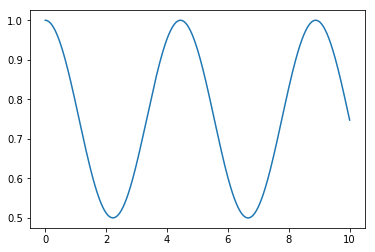

In [5]:
plt.plot(soln.t,soln.y[0])